1. imports e caminhos

In [43]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pandas.api.types import is_datetime64_any_dtype as is_dt
import numpy as np

ROOT = Path().resolve().parent
OLD_FILE = ROOT / "data" / "raw" / "merged_heatwaves_2020.csv"
NEW_FILE = ROOT / "data" / "processed" / "BSB" / "full_timeseries_with_flags.csv.gz"

2. carregar datasets

In [33]:
# ---- Ler ANTIGO (semicolon) e reconstruir timeset (robusto) ----
old = pd.read_csv(OLD_FILE, sep=";")
old.columns = [c.strip() for c in old.columns]

# Coagir Y/M/D/H para inteiros; EPW 1..24 -> 0..23 p/ datetime
for c in ["Year","Month","Day","Hour"]:
    old[c] = pd.to_numeric(old[c], errors="coerce").astype("Int64")
old["Hour_adj"] = (old["Hour"] - 1).clip(lower=0)

old["timeset"] = pd.to_datetime({
    "year":  old["Year"].astype("float").astype("Int64"),
    "month": old["Month"].astype("float").astype("Int64"),
    "day":   old["Day"].astype("float").astype("Int64"),
    "hour":  old["Hour_adj"].astype("float").astype("Int64"),
}, errors="coerce")

old = old.dropna(subset=["timeset"]).sort_values("timeset").reset_index(drop=True)

# Normalizar nomes/flags
old = old.rename(columns={
    "INMET Alert": "HW_INMET_old",
    "Ouzeau Detected": "HW_OU_old",
    "Ouzeau Event ID": "OUZ_ID_old",
    "Dry Bulb Temperature": "ta_c",
})
old["HW_OU_old"] = old["HW_OU_old"].astype(str).str.lower().isin(["true","1","yes","y","sim"])
old["HW_INMET_old"] = old["HW_INMET_old"].fillna("").str.strip().str.title().replace({"": None})

keep_cols_old = ["timeset","ta_c","HW_INMET_old","HW_OU_old"]
for col in keep_cols_old:
    if col not in old.columns:
        old[col] = np.nan
old = old[keep_cols_old]

# ---- Ler NOVO e filtrar 2020 ----
new = pd.read_csv(NEW_FILE, parse_dates=["timeset"]).sort_values("timeset").reset_index(drop=True)
old_2020 = old[old["timeset"].dt.year == 2020].reset_index(drop=True)
new_2020 = new[new["timeset"].dt.year == 2020].reset_index(drop=True)

In [37]:
# Merge exato por timestamp (one-to-one esperado para 2020)
dfc = old_2020.merge(
    new_2020[["timeset","HW_INMET_bool","HW_OU_bool","ta_c"]],
    on="timeset", how="inner", validate="one_to_one", suffixes=("_oldfile","_newfile")
)


# INMET: antigo tem níveis (Yellow/Orange/Red); novo tem bool. Vamos comparar "tem evento vs não tem".
inmet_old_has = dfc["HW_INMET_old"].notna()
inmet_new_has = dfc["HW_INMET_bool"].astype(bool)

inmet_tp = ( inmet_old_has &  inmet_new_has).sum()
inmet_fp = (~inmet_old_has &  inmet_new_has).sum()
inmet_fn = ( inmet_old_has & ~inmet_new_has).sum()
inmet_tn = (~inmet_old_has & ~inmet_new_has).sum()

prec_inmet = inmet_tp / (inmet_tp + inmet_fp) if (inmet_tp + inmet_fp)>0 else float("nan")
rec_inmet  = inmet_tp / (inmet_tp + inmet_fn) if (inmet_tp + inmet_fn)>0 else float("nan")
f1_inmet   = 2*prec_inmet*rec_inmet/(prec_inmet+rec_inmet) if (prec_inmet+rec_inmet)>0 else float("nan")

# Ouzeau: ambos booleanos
ouz_old = dfc["HW_OU_old"].astype(bool)
ouz_new = dfc["HW_OU_bool"].astype(bool)

ouz_tp = ( ouz_old &  ouz_new).sum()
ouz_fp = (~ouz_old &  ouz_new).sum()
ouz_fn = ( ouz_old & ~ouz_new).sum()
ouz_tn = (~ouz_old & ~ouz_new).sum()

prec_ouz = ouz_tp / (ouz_tp + ouz_fp) if (ouz_tp + ouz_fp)>0 else float("nan")
rec_ouz  = ouz_tp / (ouz_tp + ouz_fn) if (ouz_tp + ouz_fn)>0 else float("nan")
f1_ouz   = 2*prec_ouz*rec_ouz/(prec_ouz+rec_ouz) if (prec_ouz+rec_ouz)>0 else float("nan")

print("=== QC 2020 (hora-a-hora) ===")
print(f"INMET → TP={inmet_tp}, FP={inmet_fp}, FN={inmet_fn}, TN={inmet_tn}")
print(f"Precision={prec_inmet:.3f}, Recall={rec_inmet:.3f}, F1={f1_inmet:.3f}")
print(f"Ouzeau → TP={ouz_tp}, FP={ouz_fp}, FN={ouz_fn}, TN={ouz_tn}")
print(f"Precision={prec_ouz:.3f}, Recall={rec_ouz:.3f}, F1={f1_ouz:.3f}")

=== QC 2020 (hora-a-hora) ===
INMET → TP=122, FP=0, FN=46, TN=8616
Precision=1.000, Recall=0.726, F1=0.841
Ouzeau → TP=549, FP=6, FN=27, TN=8202
Precision=0.989, Recall=0.953, F1=0.971


In [41]:
dfc

,timeset,ta_c_oldfile,HW_INMET_old,HW_OU_old,HW_INMET_bool,HW_OU_bool,ta_c_newfile
0,2020-01-01 00:00:00,22.0,None,False,False,False,22.0
1,2020-01-01 01:00:00,22.0,None,False,False,False,22.0
2,2020-01-01 02:00:00,22.0,None,False,False,False,22.0
3,2020-01-01 03:00:00,21.3,None,False,False,False,21.3
4,2020-01-01 04:00:00,22.0,None,False,False,False,22.0
...,...,...,...,...,...,...,...
8779,2020-12-31 19:00:00,25.0,None,False,False,False,25.0
8780,2020-12-31 20:00:00,24.0,None,False,False,False,24.0
8781,2020-12-31 21:00:00,23.1,None,False,False,False,23.1
8782,2020-12-31 22:00:00,23.0,None,False,False,False,23.0


In [38]:
# ---- Utilitário: runs booleanos -> intervalos [start, end] ----
def boolean_runs_to_intervals(ts: pd.Series, mask: pd.Series):
    m = mask.fillna(False).values.astype(bool)
    if ts.empty or m.sum() == 0:
        return []
    diffs = np.diff(m.astype(int))
    starts = np.where(np.r_[m[0] and True, diffs == 1])[0]
    ends   = np.where(np.r_[diffs == -1, m[-1] and True])[0]
    return [(ts.iloc[s], ts.iloc[e]) for s, e in zip(starts, ends)]

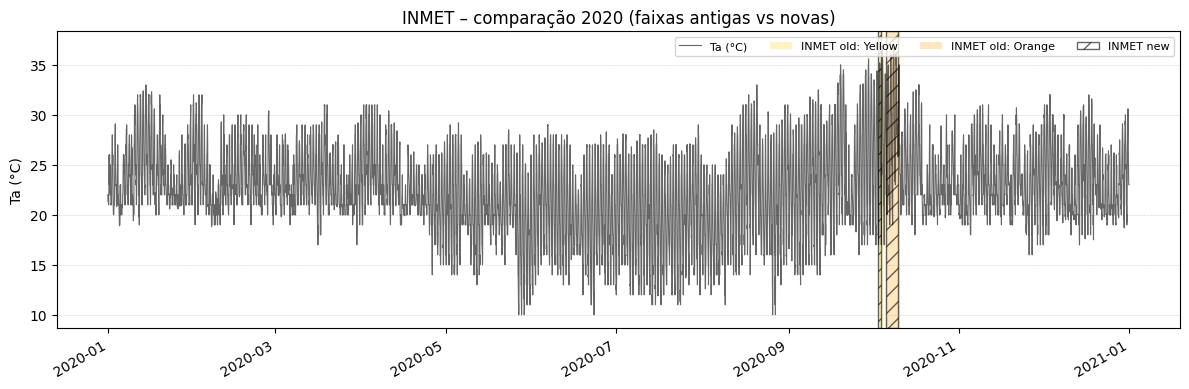

In [44]:
# =======================
# FIG 1 — INMET (faixas)
# =======================
ts = dfc["timeset"]

# escolha robusta da coluna de Ta: prioriza a do pipeline novo; cai para a antiga se necessário
if "ta_c_newfile" in dfc.columns:
    ta = dfc["ta_c_newfile"].astype(float)
elif "ta_c_oldfile" in dfc.columns:
    ta = dfc["ta_c_oldfile"].astype(float)
else:
    ta = None  # sem Ta disponível; o gráfico seguirá só com faixas

# Old: faixas por nível (Yellow/Orange/Red)
levels = {"Yellow": "#FFD700", "Orange": "#FFA500", "Red": "#FF0000"}
intervals_by_level = {
    lvl: boolean_runs_to_intervals(ts, dfc["HW_INMET_old"].fillna("").eq(lvl))
    for lvl in levels
}
# New: faixas (bool) com hachura
intervals_new = boolean_runs_to_intervals(ts, dfc["HW_INMET_bool"].fillna(False))

fig1, ax1 = plt.subplots(figsize=(12, 4))

# plota Ta somente se disponível
if ta is not None:
    ax1.plot(ts, ta, linewidth=0.8, label="Ta (°C)", color="black", alpha=0.6)

for lvl, color in levels.items():
    for s, e in intervals_by_level[lvl]:
        ax1.axvspan(s, e, facecolor=color, alpha=0.25, label=f"INMET old: {lvl}")

for s, e in intervals_new:
    ax1.axvspan(s, e, facecolor="none", edgecolor="black", hatch="//", alpha=0.6, label="INMET new")

# legenda sem duplicatas
handles, labels = ax1.get_legend_handles_labels()
seen, uniq = set(), []
for h, l in zip(handles, labels):
    if l not in seen:
        uniq.append((h, l)); seen.add(l)
ax1.legend([h for h,_ in uniq], [l for _,l in uniq], loc="upper right", ncol=4, fontsize=8)

ax1.set_title("INMET – comparação 2020 (faixas antigas vs novas)")
ax1.set_ylabel("Ta (°C)")
ax1.grid(True, axis="y", linestyle="--", linewidth=0.4, alpha=0.6)
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()


In [46]:
# dfc: merge hora-a-hora de 2020 que você já montou
inmet_old_has = dfc["HW_INMET_old"].notna()
inmet_new_has = dfc["HW_INMET_bool"].astype(bool)

# runs de divergência (old != new)
mismatch = (inmet_old_has != inmet_new_has)
grp = (mismatch != mismatch.shift()).cumsum()
div_intervals = (dfc.loc[mismatch, ["timeset"]]
                   .assign(grp=grp[mismatch])
                   .groupby("grp")["timeset"]
                   .agg(start="min", end="max", hours="count")
                   .reset_index(drop=True))
print("INMET divergências:", len(div_intervals))
div_intervals.head(10)

INMET divergências: 4


,start,end,hours
0,2020-10-02 23:00:00,2020-10-02 23:00:00,1
1,2020-10-04 01:00:00,2020-10-04 22:00:00,22
2,2020-10-05 23:00:00,2020-10-05 23:00:00,1
3,2020-10-10 01:00:00,2020-10-10 22:00:00,22


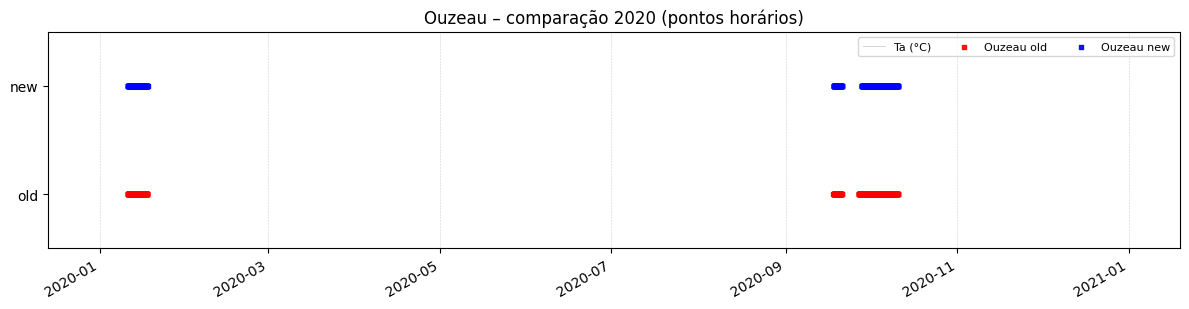

In [45]:
# ==========================
# FIG 2 — Ouzeau (raster)
# ==========================
fig2, ax2 = plt.subplots(figsize=(12, 3.2))
ax2.plot(ts, ta, linewidth=0.6, color="grey", alpha=0.4, label="Ta (°C)")

y_old, y_new = 0.2, 0.8
mask_old = dfc["HW_OU_old"].fillna(False).astype(bool)
mask_new = dfc["HW_OU_bool"].fillna(False).astype(bool)

ax2.scatter(ts[mask_old], np.full(mask_old.sum(), y_old), s=6, marker="s", color="red", alpha=0.9, label="Ouzeau old")
ax2.scatter(ts[mask_new], np.full(mask_new.sum(), y_new), s=6, marker="s", color="blue", alpha=0.9, label="Ouzeau new")

ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([y_old, y_new]); ax2.set_yticklabels(["old","new"])
ax2.set_title("Ouzeau – comparação 2020 (pontos horários)")
ax2.grid(True, axis="x", linestyle="--", linewidth=0.4, alpha=0.6)
ax2.legend(loc="upper right", ncol=3, fontsize=8)
fig2.autofmt_xdate()
plt.tight_layout()
plt.show()

In [48]:
ouz_old = dfc["HW_OU_old"].astype(bool)
ouz_new = dfc["HW_OU_bool"].astype(bool)
mismatch_ouz = (ouz_old != ouz_new)
grp = (mismatch_ouz != mismatch_ouz.shift()).cumsum()
div_ouz = (dfc.loc[mismatch_ouz, ["timeset"]]
             .assign(grp=grp[mismatch_ouz])
             .groupby("grp")["timeset"]
             .agg(start="min", end="max", hours="count")
             .reset_index(drop=True))
print("Ouzeau divergências:", len(div_ouz))
div_ouz.head(10)

Ouzeau divergências: 6


,start,end,hours
0,2020-01-10 23:00:00,2020-01-10 23:00:00,1
1,2020-01-17 23:00:00,2020-01-18 00:00:00,2
2,2020-09-17 23:00:00,2020-09-17 23:00:00,1
3,2020-09-20 23:00:00,2020-09-21 00:00:00,2
4,2020-09-26 23:00:00,2020-09-27 23:00:00,25
5,2020-10-10 23:00:00,2020-10-11 00:00:00,2


In [49]:
dfc["month"] = dfc["timeset"].dt.to_period("M").astype(str)
div_month = (dfc.assign(div_inmet=(inmet_old_has != inmet_new_has),
                        div_ouz=(ouz_old != ouz_new))
               .groupby("month")[["div_inmet","div_ouz"]].sum()
               .rename(columns={"div_inmet":"INMET_diff_hours",
                                "div_ouz":"OUZ_diff_hours"}))
div_month

,INMET_diff_hours,OUZ_diff_hours
month,,
2020-01,0,3
2020-02,0,0
2020-03,0,0
2020-04,0,0
2020-05,0,0
2020-06,0,0
2020-07,0,0
2020-08,0,0
2020-09,0,28


In [52]:
# 1) Recarrega a série completa do pipeline novo para montar a climatologia mensal 1991–2020
full_new = pd.read_csv(NEW_FILE, parse_dates=["timeset"]).sort_values("timeset")

# garante nome da coluna de temperatura do ar
ta_col = "ta_c" if "ta_c" in full_new.columns else None
if ta_col is None:
    raise RuntimeError("Não encontrei a coluna 'ta_c' no arquivo full_timeseries_with_flags.")

# diário (tmax) de toda a série
daily_all = (full_new.set_index("timeset")
             .resample("D")
             .agg(tmax_c=(ta_col, "max"))
             .reset_index())

# 2) Normais mensais (baseline 1991–2020)
baseline_mask = (daily_all["timeset"] >= "1991-01-01") & (daily_all["timeset"] <= "2020-12-31")
normals_m = (daily_all.loc[baseline_mask]
             .assign(month=lambda d: d["timeset"].dt.month)
             .groupby("month", as_index=False)["tmax_c"].mean()
             .rename(columns={"tmax_c": "tmax_norm"}))

# 3) Diário de 2020 a partir do dfc (usa ta do novo pipeline já alinhado)
daily_2020 = (dfc[["timeset", "ta_c_newfile"]]
              .set_index("timeset")
              .resample("D")
              .agg(tmax_c=("ta_c_newfile", "max"))
              .reset_index())

daily_2020["month"] = daily_2020["timeset"].dt.month
daily_2020 = daily_2020.merge(normals_m, on="month", how="left")
daily_2020["delta_c"] = daily_2020["tmax_c"] - daily_2020["tmax_norm"]

# 4) Dias de 2020 marcados como INMET (old/new)
d_old = (dfc.assign(day=dfc["timeset"].dt.normalize())
           .groupby("day")["HW_INMET_old"]
           .apply(lambda s: s.notna().any())
           .rename("old_day")
           .reset_index())
d_new = (dfc.assign(day=dfc["timeset"].dt.normalize())
           .groupby("day")["HW_INMET_bool"]
           .any()
           .rename("new_day")
           .reset_index())

# junta e encontra divergências
daily_2020 = daily_2020.merge(d_old, left_on=daily_2020["timeset"].dt.normalize(),
                              right_on="day", how="left") \
                       .merge(d_new, left_on=daily_2020["timeset"].dt.normalize(),
                              right_on="day", how="left")

daily_div = daily_2020[daily_2020["old_day"] != daily_2020["new_day"]].copy()
daily_div = daily_div[["timeset", "tmax_c", "tmax_norm", "delta_c", "old_day", "new_day"]]
daily_div = daily_div.sort_values("timeset").reset_index(drop=True)

print(f"Dias com divergência INMET em 2020: {len(daily_div)}")
daily_div.head(10)


Dias com divergência INMET em 2020: 2


,timeset,tmax_c,tmax_norm,delta_c,old_day,new_day
0,2020-10-02,34.4,29.707699,4.692301,True,False
1,2020-10-05,34.1,29.707699,4.392301,True,False
